In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall numpy
!pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.23.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.


In [ ]:
!pip install vit-pytorch
!pip install timm
!pip install vit_keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function

import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

import copy
from tqdm import tqdm

In [ ]:

# Training settings
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
def data_show(data):
    # print(data[i])
    image = data.numpy()
    # print(image[0].shape)
    image = np.transpose(image[0],[1,2,0])
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [ ]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
data_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [ ]:
def image_dir_train_test_sprit(original_dir, base_dir, train_size):
    '''
    画像データをトレインデータとテストデータにシャッフルして分割します。フォルダもなければ作成します。

    parameter
    ------------
    original_dir: str
      オリジナルデータフォルダのパス その下に各クラスのフォルダがある
    base_dir: str
      分けたデータを格納するフォルダのパス　そこにフォルダが作られます
    train_size: float
      トレインデータの割合
    '''
    try:
        os.mkdir(base_dir)
    except FileExistsError:
        print(base_dir + "は作成済み")

    #クラス分のフォルダ名の取得
    dir_lists = os.listdir(original_dir)
    dir_lists = [f for f in dir_lists if os.path.isdir(os.path.join(original_dir, f))]
    original_dir_path = [os.path.join(original_dir, p) for p in dir_lists]

    num_class = len(dir_lists)

    # フォルダの作成(トレインとバリデーション)
    try:
        train_dir = os.path.join(base_dir, 'train')
        os.mkdir(train_dir)
    except FileExistsError:
        print(train_dir + "は作成済み")

    try:
        validation_dir = os.path.join(base_dir, 'validation')
        os.mkdir(validation_dir)
    except FileExistsError:
        print(validation_dir + "は作成済み")

    #クラスフォルダの作成
    train_dir_path_lists = []
    val_dir_path_lists = []
    for D in dir_lists:
        train_class_dir_path = os.path.join(train_dir, D)
        try:
            os.mkdir(train_class_dir_path)
        except FileExistsError:
            print(train_class_dir_path + "は作成済み")
        train_dir_path_lists += [train_class_dir_path]
        val_class_dir_path = os.path.join(validation_dir, D)
        try:
            os.mkdir(val_class_dir_path)
        except FileExistsError:
            print(val_class_dir_path + "は作成済み")
        val_dir_path_lists += [val_class_dir_path]


    #元データをシャッフルしたものを上で作ったフォルダにコピーします。
    #ファイル名を取得してシャッフル
    for i,path in enumerate(original_dir_path):
        files_class = os.listdir(path)
        random.shuffle(files_class)
        # 分割地点のインデックスを取得
        num_bunkatu = int(len(files_class) * train_size)
        #トレインへファイルをコピー
        for fname in files_class[:num_bunkatu]:
            src = os.path.join(path, fname)
            dst = os.path.join(train_dir_path_lists[i], fname)
            shutil.copyfile(src, dst)
        #valへファイルをコピー
        for fname in files_class[num_bunkatu:]:
            src = os.path.join(path, fname)
            dst = os.path.join(val_dir_path_lists[i], fname)
            shutil.copyfile(src, dst)
        print(path + "コピー完了")


In [ ]:
!pip install torchinfo

In [ ]:
!pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install hydra-core --upgrade
!pip install timm
!pip install fairscale
!pip install sknw

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.10.2+cu113 (from versions: 1.11.0, 1.11.0+cu113, 1.12.0, 1.12.0+cu113, 1.12.1, 1.12.1+cu113, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1)
ERROR: No matching distribution found for torch==1.10.2+cu113
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-suuq3p5g
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-suuq3p5g
  Resolved https://github.com/facebookresearch/fvcore.git to commit 4d14ad0a8eb3ec002c87e5d3421a0d498dccebcc
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65324 sha256=6d113b88ba8c2b56842668cb2312f11a3e330bee82ce348c7c8e31f277d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332104 sha256=d99861125dc2b23956c37c6ca0a13baec07c2c16f3940fa8865774dd85cecd1a
  Stored in directory: /root/.cache/pip/wheels/78/a4/c0/fb0a7ef03cff161611c3fa40c6cf898f76e58ec421b88e8cb3
Successfully built fairscale


In [ ]:
%cd "/content/drive/MyDrive/zemi2/detectron2_main"
from detectron2.structures.boxes import Boxes
import pandas as pd
from sklearn import cluster, preprocessing, mixture
from matplotlib.pyplot import axes
from matplotlib import pyplot as plt
import math
from skimage.morphology import medial_axis, skeletonize
from scipy.ndimage import distance_transform_edt

import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import cv2
from google.colab.patches import cv2_imshow
from torchvision import datasets, transforms

/content/drive/MyDrive/zemi2/detectron2_main


In [ ]:
%cd "/content/drive/MyDrive/zemi2/DSE_skeleton_pruning_master"

/content/drive/MyDrive/zemi2/DSE_skeleton_pruning_master


In [ ]:
!pip install -r requirement.txt
!python setup.py build_ext --inplace

Compiling dsepruning/dse_helper.pyx because it depends on /usr/local/lib/python3.10/dist-packages/numpy/__init__.cython-30.pxd.
[1/1] Cythonizing dsepruning/dse_helper.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/drive/MyDrive/zemi2/DSE_skeleton_pruning_master/dsepruning/dse_helper.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
performance hint: dsepruning/dse_helper.pyx:7:5: Exception check on 'circle' will always require the GIL to be acquired.
Possible solutions:
	1. Declare 'circle' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
	2. Use an 'int' return type on 'circle' to allow an error code to be returned.
running build_ext
building 'dsepruning.dse_helper' extension
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -

In [ ]:
from dsepruning import skel_pruning_DSE
# from DSE_skeleton_pruning_master.dsepruning import skel_pruning_DSE

In [ ]:
import math
import operator
import heapq
from sklearn.cluster import DBSCAN

import statistics
import scipy.stats
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


from detectron2.data.datasets import register_coco_instances
register_coco_instances("chrome", {},
"/content/drive/MyDrive/zemi2/cell/InstanceData/cellimages/cellimages.json",
"/content/drive/MyDrive/zemi2/cell/InstanceData/cellimages")
# register_coco_instances("chromes", {},
# "/content/drive/MyDrive/zemi2/cell/InstanceData/cell2chromesomes/cell2chromesomes.json",
# "/content/drive/MyDrive/zemi2/cell/InstanceData/cell2chromesomes")

In [ ]:
import numpy as np
print(np.__version__)

1.23.5


In [ ]:
!pip install vit-pytorch
print(np.__version__)

1.23.5


In [ ]:
!pip install vit_keras
print(np.__version__)

1.23.5


In [ ]:
!pip install tensorflow-addons
print(np.__version__)

1.23.5


In [ ]:
!pip install tqdm
print(np.__version__)

1.23.5


In [ ]:
from matplotlib import pyplot as plt
### 染色体の切り取りとshow_img
def crop_rect(img, rect):
    center, size, angle = rect
    center = tuple(map(int, center))  # float -> int
    size = tuple(map(int, size))  # float -> int
    h, w = img.shape[:2]  # 画像の高さ、幅
    # 画像を回転する。
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated = cv2.warpAffine(img, M, (w, h))
    # 切り抜く。
    cropped = cv2.getRectSubPix(rotated, size, center)
    return cropped
def bounding_box(img, rect):
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box
def show_img(img, vmin=0, vmax=255, title=None):
        #カラー(ndim=次元数=3 -> RGBの３色)
        #CV2のRGB３色に変換
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img, vmin=vmin, vmax=vmax)
    #座標軸非表示
    plt.axis('off')
    #タイトル設定
    plt.title(title)
    #グラフ表示
    plt.show()
def get_rects(masking):
    retval, bin = cv2.threshold(masking, 0, 255, cv2.THRESH_OTSU )
    # 255から1に変換, 1と0の二値画像に変換
    bin[bin > 0] = 255
    ### 輪郭を抽出
    contours, hierarchy = cv2.findContours(masking, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = []
    for i, cnt in enumerate(contours):
        rect = cv2.minAreaRect(cnt)
        rects.append(rect)
    return rects,bin
def get_line(skelton, bin, draw_img):
    pixcel_list = []
    yoko = bin.shape[1]
    tate = bin.shape[0]
    # print(yoko, tate)
    if tate >= yoko:
        for i in range(tate):
            for j in range(yoko):
                if skelton[i][j] == 1:
                    pixcel_list.append([j, i])
    if yoko > tate:
        for i in range(yoko):
            for j in range(tate):
                if skelton[j][i]:
                    pixcel_list.append([i, j])
    skel_line = np.array(pixcel_list)
    result = cv2.polylines(draw_img, [skel_line], isClosed=False, color=(0, 255, 0), thickness = 1)
    return skel_line, result

###始点と終点のユークリッド距離
def dist_epoint(x1y1, x2y2):
    D = np.linalg.norm(x1y1-x2y2)
    return D

def bent(skel_line):
  L = cv2.arcLength(skel_line, False)
  x1y1 = np.array(skel_line[0])
  x2y2 = np.array(skel_line[len(skel_line)-1])
  D = dist_epoint(x1y1,x2y2)
  bent_per = D/L
  return bent_per, D, L

def chrome_judge(masks_np,im, draw_img, save_path, model,scores, out_class,handan_list,Vit_list,Alg_list,errViTlist,errAlglist):
    h_n = 0
    V_A_n = 0
    e_V_A_n=0
    RED = '\033[31m'
    END = '\033[0m'
    # Y = input('Start！！　:')
    all_cnt = 0
    chrome_list = []
    chrome_list6=[]
    chrome_list7=[]
    chrome_list8=[]
    chrome_list9=[]
    ##目視
    mks_list6=[]
    mks_list7=[]
    mks_list8=[]
    mks_list9=[]
    sin_list=[]
    lum_list=[]
    unb_list=[]

    ###交換判定適合率
    ExPred_06 = []
    ExPred_07 = []
    ExPred_08 = []
    ExPred_09 = []
    ###回数適合率
    NumPred_06 = []
    NumPred_07 = []
    NumPred_08 = []
    NumPred_09 = []
    ###目視の交換回数
    ExNum = []
    MokushiNum = []
    errExNum = []
    errMokushiNum = []

    size =224
    image_size = (224,224)

    ### マスク
    masks_np = np.empty((len(masks[1])))
    masks_np = masks.to('cpu').detach().numpy().copy()
    # print(masks_np)
    masks_np = masks_np.astype(np.uint8)
    # print(masks_np[num][1][2])
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
          if masks_np[1][i][j] > 0:
              masks_np[1][i][j] = 255
    masking = masks_np[1]
    chrome_num = len(masks_np)
    for num in range(len(masks_np)):
      # print(num)
      ### num番目をマスク
      masks_np = np.empty((len(masks[num])))
      masks_np = masks.to('cpu').detach().numpy().copy()
      masks_np = masks_np.astype(np.uint8)
      masks_np = np.where(masks_np == 1, 255, masks_np)
      masking = masks_np[num]
      rects, bin=get_rects(masking)
      for i, rect in enumerate(rects):
        try:
          ### 切り抜く。
          cropped_color =  crop_rect(im, rect)
          x = crop_rect(im, rect)
          # ### HSVのvだけ編集
          # h,s,v = cv2.split(cv2.cvtColor(cropped_color,cv2.COLOR_BGR2HSV))  # 色空間をBGRからHSVに変換
          # v2 = cv2.equalizeHist(v)
          # cropped_color = cv2.cvtColor(cv2.merge((h,s,v2)), cv2.COLOR_HSV2BGR)
        except:
          chrome_num -= 1
          break;

        cropped_bin = crop_rect(bin, rect)
        if cropped_bin is None:
            chrome_num -= 1
            break;
        cropped_bin[cropped_bin >= 1] =255


        ###カラーマスク
        cropped_bin_m = cv2.cvtColor(cropped_bin[:, :, np.newaxis], cv2.COLOR_GRAY2BGR)
        crop_mask = cv2.bitwise_and(cropped_color, cropped_bin_m)
        crop_mask_g = cv2.cvtColor(crop_mask, cv2.COLOR_BGR2GRAY)
        black_pixels = (crop_mask_g == 0)
        crop_mask_g[black_pixels] = 255
        yoko = crop_mask_g.shape[1]
        tate = crop_mask_g.shape[0]
        box = bounding_box(cropped_color, rect)

        ### 保存
        if tate< yoko:#同じ方向に変換
            cropped_color = cv2.rotate(cropped_color, cv2.ROTATE_90_CLOCKWISE)
            x = cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE)
            cropped_bin = cv2.rotate(cropped_bin, cv2.ROTATE_90_CLOCKWISE)
            crop_mask = cv2.rotate(crop_mask, cv2.ROTATE_90_CLOCKWISE)
            crop_mask_g = cv2.rotate(crop_mask_g, cv2.ROTATE_90_CLOCKWISE)
            yoko = crop_mask_g.shape[1]
            tate = crop_mask_g.shape[0]
        # show_img(cropped_color)
        # ??????
        ### 骨格検出（DSE)
        th = cropped_bin
        # show_img(th)
        th[th >= 1] = 1
        skel = skeletonize(th)
        dist = distance_transform_edt(th, return_indices=False, return_distances=True)

        try:
          # print('new skel')
          new_skel = skel_pruning_DSE(skel, dist, 100)
        except:
          chrome_num -= 1
          # print('bAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
          break;

        ### 画像にスケルトンを合成
        skel_line, result2 = get_line(new_skel, cropped_bin, cropped_color)
        if len(skel_line)==0:

          break;
        bent_per, D, L = bent(skel_line)
        ###モデルに画像を入力
        x =  cv2.resize(x, image_size)
        ###正規化
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        imgTensor = transforms.ToTensor()(x)
        transform = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        norm_imgtensor = transform(imgTensor)
        x = norm_imgtensor.unsqueeze(0)
        # data_show(x)

        if out_class[num]==0:
          # print('single')
          # sin = input('ok:0 no:1  :')
          # sin_list.append(int(sin))
          ###染色体？？
          Judgeable = int(handan_list[h_n])
          # print('判断可能（0）不可能（1）:'+str(Judgeable))
          h_n += 1
          sin_list.append(Judgeable)
        else:
          # print('lump')
          # lum = input('ok:0 no:1  :')
          Judgeable = 1
          lum_list.append(Judgeable)
        if Judgeable == 0:
            ExSelf = int(Vit_list[V_A_n])
            # print('交換なし(0)？あり(1)？ :'+str(ExSelf))
            ExNum.append(ExSelf)
            NumSelf = int(Alg_list[V_A_n])
            # print('交換回数 ：'+str(NumSelf))
            MokushiNum.append(NumSelf)
            if scores[num]>=0.6:
                mks_list6.append(NumSelf)
            if scores[num]>=0.7:
                mks_list7.append(NumSelf)
            if scores[num]>=0.8:
                mks_list8.append(NumSelf)
            if scores[num]>=0.9:
                mks_list9.append(NumSelf)
            V_A_n += 1
        else:
            # print('judgeable==1')
            errExSelf = int(errViTlist[e_V_A_n])
            ExNum.append(errExSelf)
            errNumSelf = int(errAlglist[e_V_A_n])
            MokushiNum.append(errNumSelf)
            if scores[num]>=0.6:
                mks_list6.append(NumSelf)
            if scores[num]>=0.7:
                mks_list7.append(NumSelf)
            if scores[num]>=0.8:
                mks_list8.append(NumSelf)
            if scores[num]>=0.9:
                mks_list9.append(NumSelf)
            e_V_A_n+=1
        # x = x/ 255.0
        x.to('cpu')
        ###推論
        outputs = model(x)
        pred = outputs.argmax(1)

        # print(outputs)
        if pred == 0:
            ####交換回数を調査
            judge = SCE_judge(crop_mask_g,crop_mask,skel_line,size)
            cv2.drawContours(draw_img, [box], 0, (0,0,255), 2)
            cv2.putText(draw_img,
                      text='ex:'+str(judge),
                      org=(box[0][0],box[0][1]),
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=1.0,
                      color=(0, 255, 0),
                      thickness=2,
                      lineType=cv2.LINE_4)
            ###交換あり
            if ExSelf == 1:
              ###正解ラベルと一致
              # print('ex correct!')
              # if Judgeable == 0:
                if scores[num]>=0.6 :
                    ExPred_06.append(0)
                if scores[num]>=0.7:
                    ExPred_07.append(0)
                if scores[num]>=0.8:
                    ExPred_08.append(0)
                if scores[num]>=0.9:
                    ExPred_09.append(0)
                ####交換回数を調査
                judge = SCE_judge(crop_mask_g,crop_mask,skel_line,size)
                ###回数が合致しているのか確認
                if judge == NumSelf:
                  ###正解ラベルと一致
                  # if Judgeable == 0:
                    if scores[num]>=0.6:
                        NumPred_06.append(0)
                    if scores[num]>=0.7:
                        NumPred_07.append(0)
                    if scores[num]>=0.8:
                        NumPred_08.append(0)
                    if scores[num]>=0.9:
                        NumPred_09.append(0)
                else:
                  ###間違い（回数が異なる）
                  # if Judgeable == 0:

                    print(RED + '画像処理判断:'+str(judge)+END)
                    if scores[num]>=0.6:
                        NumPred_06.append(1)
                    if scores[num]>=0.7:
                        NumPred_07.append(1)
                    if scores[num]>=0.8:
                        NumPred_08.append(1)
                    if scores[num]>=0.9:
                        NumPred_09.append(1)
                ####細胞画像に結果を書き込む(陽性）
                cv2.drawContours(draw_img, [box], 0, (0,0,255), 2)
                cv2.putText(draw_img,
                          text='ex:'+str(judge),
                          org=(box[0][0],box[0][1]),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                          fontScale=1.0,
                          color=(0, 255, 0),
                          thickness=2,
                          lineType=cv2.LINE_4)
            if ExSelf == 0:
              ###間違い（SCEではない）
              # print('ex fault')
              # if Judgeable == 0:
                if scores[num]>=0.6:
                    ExPred_06.append(1)
                if scores[num]>=0.7:
                    ExPred_07.append(1)
                if scores[num]>=0.8:
                    ExPred_08.append(1)
                if scores[num]>=0.9:
                    ExPred_09.append(1)
                print(RED + 'ViTのミス(交換)' + END)
            if bent_per<0.6:####染色体曲がっているぞ！！
              # cv2.drawContours(draw_img, [box], 0, (255,0,100), 2)
              # cv2.putText(draw_img,
              #         text='bent(ex)',
              #         org=(box[0][0],box[0][1]),
              #         fontFace=cv2.FONT_HERSHEY_SIMPLEX,
              #         fontScale=1.0,
              #         color=(255, 0, 100),
              #         thickness=2,
              #         lineType=cv2.LINE_4)
              chrome_num -= 1
            ####細胞画像に結果を書き込む(陽性）

        ####ViTが交換なしと判断
        elif pred == 1:
          ####細胞画像に結果を書き込む（陰性）
          cv2.drawContours(draw_img, [box], 0, (0,255,0), 2)
          cv2.putText(draw_img,
                      text='noex',
                      org=(box[0][0],box[0][1]),
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=1.0,
                      color=(0, 255, 0),
                      thickness=2,
                      lineType=cv2.LINE_4)
          ###交換なし
          if ExSelf == 1:

              if scores[num]>=0.6 :
                  ExPred_06.append(1)
              if scores[num]>=0.7 :
                  ExPred_07.append(1)
              if scores[num]>=0.8 :
                  ExPred_08.append(1)
              if scores[num]>=0.9:
                  ExPred_09.append(1)
              print(RED + 'ViTのミス(交換なし)' + END)
          if ExSelf == 0:

              # print('noex corecct!')
              ###正解
              if scores[num]>=0.6 :
                  ExPred_06.append(0)
              if scores[num]>=0.7 :
                  ExPred_07.append(0)
              if scores[num]>=0.8 :
                  ExPred_08.append(0)
              if scores[num]>=0.9:
                  ExPred_09.append(0)

          chrome_list.append(0)
          if scores[num]>=0.6:
                chrome_list6.append(0)
          if scores[num]>=0.7:
                chrome_list7.append(0)
          if scores[num]>=0.8:
                chrome_list8.append(0)
          if scores[num]>=0.9:
                chrome_list9.append(0)

    return all_cnt,img_result2,chrome_num,chrome_list,ExPred_06,ExPred_07,ExPred_08,ExPred_09,NumPred_06, NumPred_07,NumPred_08,NumPred_09,ExNum, MokushiNum,sin_list,lum_list, errExNum,errMokushiNum,chrome_list6,chrome_list7,chrome_list8,chrome_list9,mks_list6,mks_list7,mks_list8,mks_list9
def SCE_judge(crop_mask_g,crop_mask,skel_line,size):
  tmp_list = []
  ### 極値検出
  result, grob_list = exmin_point3(crop_mask_g, crop_mask)
  # show_img(result)
  ### 中心線
  line = []
  yoko_list = skel_line[:,0]###横の座標
  trimean = scipy.stats.trim_mean(yoko_list, 0.1)
  for j in range(size):
      line.append([int(trimean), j])
  line = np.array(line)
  ### meanshift
  X=grob_list
  center_list, result = DBMean(grob_list, result)
  # show_img(result)
  ### 数える
  cnt = count(crop_mask_g, line, center_list)
  if cnt <= 0.5:
    cnt = 0
  else:
    cnt = math.ceil(cnt)
  return cnt
def exmin_point3(gray_img, draw_img):
    pixcel_list = []

    tate = draw_img.shape[0]
    for j in range(5, tate-5):
        if 100< np.var(np.delete(gray_img[j], np.argwhere(gray_img[j] == 255))):
            unique_labels = np.unique(heapq.nsmallest(2, gray_img[j]))
            for label in unique_labels:
                yoko_point = np.where(gray_img[j]==label)
                for i in range(len(yoko_point[0])):
                    py = j
                    px = yoko_point[0][i]
                    pixcel_list.append([px, py])
                    result = cv2.circle(draw_img, (px, py), 1, (255, 255, 255),
                                            thickness = 1, lineType=cv2.LINE_AA)


    np_p_list = np.array(pixcel_list)
    return result, np_p_list
def DBMean(grob_list, draw_img):
    X=grob_list
    db = DBSCAN(eps = 3, min_samples=10,algorithm='brute').fit(X)
    unique_labels = np.unique(db.labels_)
    xym_list = []
    for label in unique_labels:
        X_label = X[np.where(db.labels_==label)]
        x, y = np.mean(X_label[:, 0]), np.mean(X_label[:, 1])
        xym_list.append([x,y])
        for i in range(len(xym_list)):
            px=int(xym_list[i][0])
            py = int(xym_list[i][1])
            result = cv2.circle(draw_img, (px, py), 1, (0, 255, 255),
                                thickness = 1, lineType=cv2.LINE_AA)

    return xym_list, result
def count(img, line, cent_list):
    tmp_list = []
    count=0.5
    line = line[:, ::-1]
    cent_list = np.array(sorted(cent_list,
                        key=operator.itemgetter(1)))
    for i in range(cent_list.shape[0]):
        # print('重心' +str(cent_list[i]))
        cent_yoko = cent_list[i][0]
        cent_tate = cent_list[i][1]
        ###lineと重心が最も近いところ
        min_distance=100
        for j in range(line.shape[0]):
          distance =abs(line[j][0]-cent_tate)
          if min_distance>distance:
              tmp = line[j]
              min_distance=distance
        # print('基準線:'+str(tmp))
        tmp_yoko = tmp[1]
        # print('kizyun:'+str(tmp_yoko))
        # print('zyuusin:'+str(cent_yoko))
        if cent_yoko>tmp_yoko:
            tmp_list.append(1)
        if cent_yoko<=tmp_yoko:
            tmp_list.append(0)
    fire = tmp_list[0]

    for i in range(len(tmp_list)):
        # print('['+str(tmp_list[i]) + ' : '+ str(cent_list[i]) + ']')
        if fire != tmp_list[i]:
            fire = tmp_list[i]
            count += 0.49
        # print(count)

    return count


In [ ]:
import timm
import torch
from tqdm import tqdm
tmp = 0
ExSumlist6 = []
NumSumlist6 = []
ExSumlist7 = []
NumSumlist7 = []
ExSumlist8 = []
NumSumlist8 = []
ExSumlist9 = []
NumSumlist9 = []
ExSum6 = 0
NumSum6 = 0
ExSum7 = 0
NumSum7 = 0
ExSum8 = 0
NumSum8 = 0
ExSum9 = 0
NumSum9 = 0

Vit_all06=0
Alg_all06=0
Vit_all07=0
Alg_all07=0
Vit_all08=0
Alg_all08=0
Vit_all09=0

SCE判定main

In [ ]:
####初期値
tmp = 0
ExSumlist6 = []
NumSumlist6 = []
ExSumlist7 = []
NumSumlist7 = []
ExSumlist8 = []
NumSumlist8 = []
ExSumlist9 = []
NumSumlist9 = []
ExSum6 = 0
NumSum6 = 0
ExSum7 = 0
NumSum7 = 0
ExSum8 = 0
NumSum8 = 0
ExSum9 = 0
NumSum9 = 0
Vit_all06=0
Alg_all06=0
Vit_all07=0
Alg_all07=0
Vit_all08=0
Alg_all08=0
Vit_all09=0
Alg_all09=0
####15回ViTをランダムにシャッフル、各モデル時の精度
for k in range(15):
  ####start:ViT Train
    print('■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■')
    train_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train'
    if os.path.exists(train_dir):
      # print('Y')
      shutil.rmtree(train_dir)
    valtest_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest'
    if os.path.exists(valtest_dir):
      # print('yy')
      shutil.rmtree(valtest_dir)
    os.mkdir(train_dir)
    os.mkdir(valtest_dir)
    train_size = 0.6
    base_dir =  '/content/drive/MyDrive/zemi2/231101vit_sfl/base_data'
    data_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train'
    image_dir_train_test_sprit(base_dir, data_dir, train_size)
    count_file = 0
    train_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/train/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(train_dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(train_dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    count_file = 0
    dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/validation/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    val_size = 119/219
    base_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/validation/'
    val_test_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/'
    image_dir_train_test_sprit(base_dir, val_test_dir, val_size)
    count_file = 0
    val_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/train/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(val_dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(val_dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    count_file = 0
    test_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/validation/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(test_dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(test_dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    train_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/train'
    val_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/train'
    test_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/validation'
    device = 'cuda:0'
    train_dataset_dir = Path(train_dir)
    val_dataset_dir = Path(val_dir)
    test_dataset_dir = Path(test_dir)
    train_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomAffine([0,30], scale=(0.8, 1.2)),
            ###９０度回転
            # transforms.RandomRotation(degrees = 90),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )

    val_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )

    test_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )
    train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
    valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)
    test_data = datasets.ImageFolder(test_dataset_dir, test_transforms)

    train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
    valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=False)
    test_loader = DataLoader(dataset = test_data, batch_size=1, shuffle=False)
    model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
    model = model.to(device)
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    batch_size = 16


    best_loss = None

    # Accuracy計算用の関数
    def calculate_accuracy(output, target):
        output = (torch.sigmoid(output) >= 0.5)
        target = (target == 1.0)
        accuracy = torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
        return accuracy

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)


        print()
    device2 = torch.device('cpu')

    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    for i in range(epochs):
        train_acc2 = train_acc_list[i].to(device2)
        train_acc3 = train_acc2.clone().numpy()
        train_acc.append(train_acc3)

        train_loss2 = train_loss_list[i].to(device2)
        train_loss3 = train_loss2.clone().detach().numpy()
        train_loss.append(train_loss3)

        val_acc2 = val_acc_list[i].to(device2)
        val_acc3 = val_acc2.clone().numpy()
        val_acc.append(val_acc3)

        val_loss2 = val_loss_list[i].to(device2)
        val_loss3 = val_loss2.clone().numpy()
        val_loss.append(val_loss3)

    best_loss = val_loss
    model_path = '/content/drive/MyDrive/zemi2/231127vit/model/ViTmodel.pth'
    torch.save(model.state_dict(), model_path)
    ####End:ViT train
    #### Mask R-CNNの準備
    chrome_metadata = MetadataCatalog.get("chrome")
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 1クラスのみ
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/zemi2/231226/model_final (1).pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
    cfg.MODEL.DEVICE = "cpu"
    predictor = DefaultPredictor(cfg)
    #model
    model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
    # Load a model
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    ####細胞のSCE判定を行う
    ExSum6 = 0
    NumSum6= 0
    ExSum7 = 0
    NumSum7 = 0
    ExSum8 = 0
    NumSum8 = 0
    ExSum9 = 0
    NumSum9 = 0

    Ex6 = 0
    Num6= 0
    Ex7 = 0
    Num7 = 0
    Ex8 = 0
    Num8 = 0
    Ex9 = 0
    Num9 = 0
    ###lisは、細胞画像の番号(この数値以外の細胞のSCE回数正解データはない、必要ならば各自で作成)
    lis = [50,51,52,53,54,55,57,58]
    c_per_ave=0
    c_per6_ave=0
    c_per7_ave=0
    c_per8_ave=0
    c_per9_ave=0
    m_per_ave=0
    m_per6_ave=0
    m_per7_ave=0
    m_per8_ave=0
    m_per9_ave=0
    ###heikin
    Vit06=0
    Vit07=0
    Vit08=0
    Vit09=0
    Alg06=0
    Alg07=0
    Alg08=0
    Alg09=0
    ###テスト
    for i in lis:
      lum_per = 0
      all_lum = 0
      all_sin = 0

      sin_list = []
      lum_list = []
      RED = '\033[31m'
      END = '\033[0m'
      ###保存
      save_path = '/content/drive/MyDrive/zemi2/cell/ViT0520/wt220219'###多分使用していない
      imgPath = "/content/drive/MyDrive/zemi2/cell/cell/0427_wt30min/"+str(i)+".png"####野生株細胞画像
      # imgPath = "/content/drive/MyDrive/zemi2/cell/cell/0427_blm30min/"+str(t)+".png"
      im = cv2.imread(imgPath)
      img_result2 = cv2.imread(imgPath)
      outputs = predictor(im)
      masks =  outputs["instances"].to("cpu").pred_masks
      masks_np = np.empty((len(masks[1])))
      masks_np = masks.to('cpu').detach().numpy().copy()
      masks_np = masks_np.astype(np.uint8)
      out_class = outputs["instances"].to("cpu").pred_classes
      scores = outputs["instances"].to("cpu").scores
      ### マスク
      masks_np = np.empty((len(masks[1])))
      masks_np = masks.to('cpu').detach().numpy().copy()
      # print(masks_np)
      masks_np = masks_np.astype(np.uint8)
      if i==50:
        ####Chrome_judgeへの引数、正解ラベル(listで引数をしているが、未知の染色体にはinput()などを利用してリアルタイムで正誤を判定可能)
        ####hanndan_list:０：単一　１：それ以外
        ####Vit_list:０：NO　SCE　１：Yes　SCE
        ####Alg_list:SCE交換回数(基本的にSCE陽性のみ１以上数値が記入されてる )
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Vit_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
        Alg_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
        errViTlist=[]
        errAlglist=[]
      if i==51:
        handan_list =[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
        Vit_list = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
        Alg_list = [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
        errViTlist=[0, 0, 0, 1, 0]
        errAlglist=[0, 0, 0, 1, 0]
      if i==52:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Vit_list = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
        Alg_list = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
        errViTlist=[0]
        errAlglist=[0]
      if i==53:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
        Vit_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
        Alg_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
        errViTlist=[0, 0, 0, 0]
        errAlglist=[0, 0, 0, 0]
      if i==54:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
        Vit_list = [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
        Alg_list = [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1]
        errViTlist=[0, 1, 0, 0]
        errAlglist=[0, 1, 0, 0]
      if i==55:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        Vit_list = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Alg_list = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        errViTlist=[0, 0, 0, 0]
        errAlglist=[0, 0, 0, 0]
      if i==57:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]
        Vit_list = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
        Alg_list = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0]
        errViTlist=[0, 0, 0, 0, 0, 0, 0]
        errAlglist=[0, 0, 0, 0, 0, 0, 0]
      if i==58:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
        Vit_list = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
        Alg_list = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
        errViTlist=[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
        errAlglist=[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
      ####img_result2:提案システムの結果画像が入っています
      all_cnt, img_result2, chrome_num, chrome_list,Exlist6, Exlist7,Exlist8,Exlist9,\
      Numlist6, Numlist7,Numlist8,Numlist9,ExNum, MokushiNum, sin_list,lum_list,\
      errExNum,errMokushiNum\
      ,chrome_list6,chrome_list7,chrome_list8,chrome_list9\
      ,mks_list6,mks_list7,mks_list8,mks_list9\
      = chrome_judge(masks_np,im, img_result2, save_path,model, scores, out_class,handan_list,Vit_list,Alg_list,errViTlist,errAlglist)
      print('---------------------')
      print(i)
      print('count excange = '+str(all_cnt))
      print('検出染色体数'+str(len(chrome_list)))
      if len(chrome_list)>0:
        c_per = sum(chrome_list)/len(chrome_list)
      else:
        c_per=0
      # print("per_exchange = "+str(c_per))
      try:
        c_per6 = sum(chrome_list6)/len(chrome_list6)
      # print("per_exchange6 = "+str(c_per6))
      except:
        c_per6=0
      try:
        c_per7 = sum(chrome_list7)/len(chrome_list7)
      # print("per_exchange7 = "+str(c_per7))
      except:
        c_per7=0
      try:
        c_per8 = sum(chrome_list8)/len(chrome_list8)
      # print("per_exchange8 = "+str(c_per8))
      except:
        c_per8=0
      try:
        c_per9 = sum(chrome_list9)/len(chrome_list9)
      except:
        c_per9=0
      # print("per_exchange9 = "+str(c_per9))
      c_per_ave+=c_per
      c_per6_ave+=c_per6
      c_per7_ave+=c_per7
      c_per8_ave+=c_per8
      c_per9_ave+=c_per9
      try:
        c_per_Mokushi = sum(MokushiNum)/len(MokushiNum)
      except:
        c_per_Mokushi=0
      try:
      # print("mks_exchange = "+str(c_per_Mokushi))
        m_per6 = sum(mks_list6)/len(mks_list6)
      except:
        m_per6=0
      try:
        # print("mks_exchange6 = "+str(c_per6))
        m_per7 = sum(mks_list7)/len(mks_list7)
      except:
        m_per7=0
      try:
        # print("mks_exchange7 = "+str(m_per7))
        m_per8 = sum(mks_list8)/len(mks_list8)
      except:
        m_per8=0
      # print("mks_exchange8 = "+str(m_per8))
      try:
        m_per9 = sum(mks_list9)/len(mks_list9)
      except:
        m_per9=0
      # print("per_exchange9 = "+str(m_per9))
      m_per_ave+=c_per_Mokushi
      m_per6_ave+=m_per6
      m_per7_ave+=m_per7
      m_per8_ave+=m_per8
      m_per9_ave+=m_per9
      ###交換正解率,回数正解率
      if len(Exlist6)==0:
        print('-----0.6検出数:0')
        print(RED + '交換正解率0.6：0'+END)
        Vit06+=0
      else:
        ExPred6 = 1-(sum(Exlist6)/len(Exlist6))
        print('-----0.6検出数:'+str(len(Exlist6)))
        print(RED + '交換正解率0.6：'+str(ExPred6)+END)
        Vit06+=ExPred6
      if len(Numlist6)==0:
        print('-----0.6画像処理対象数:0')
        print(RED + '回数正解率0.6：0'+END)
        Alg06+=0
      else:
        NumPred6 =  1-(sum(Numlist6)/len(Numlist6))
        print('-----0.6画像処理対象数:'+str(len(Numlist6)))
        print(RED + '回数正解率0.6：'+str(NumPred6)+END)
        Alg06+=NumPred6
    ####
      if len(Exlist7)==0:
        print('-----0.7検出数:0')
        print(RED + '交換正解率0.7：0'+END)
        Vit07+=0
      else:
        ExPred7 = 1-(sum(Exlist7)/len(Exlist7))
        print('-----0.7検出数:'+str(len(Exlist7)))
        print(RED + '交換正解率0.7：'+str(ExPred7)+END)
        Vit07+=ExPred7
      if len(Numlist7)==0:
        print('-----0.7画像処理対象数:0')
        print(RED + '回数正解率0.7：0'+END)
        Alg07+=0
      else:
        NumPred7 =  1-(sum(Numlist7)/len(Numlist7))
        print('-----0.7画像処理対象数:'+str(len(Numlist7)))
        print(RED + '回数正解率0.7：'+str(NumPred7)+END)
        Alg07+=NumPred7
    ###
      if len(Exlist8)==0:
        print('-----0.8検出数:0')
        print(RED + '交換正解率0.8：0'+END)
        Vit08+=0
      else:
        ExPred8 = 1-(sum(Exlist8)/len(Exlist8))
        print('-----0.8検出数:'+str(len(Exlist8)))
        print(RED + '交換正解率0.8：'+str(ExPred8)+END)
        Vit08+=ExPred8
      if len(Numlist8)==0:
        print('-----0.8画像処理対象数:0')
        print(RED + '回数正解率0.8：0'+END)
        Alg08+=0
      else:
        NumPred8 =  1-(sum(Numlist8)/len(Numlist8))
        print('-----0.8画像処理対象数:'+str(len(Numlist8)))
        print(RED + '回数正解率0.8：'+str(NumPred8)+END)
        Alg08+=NumPred8
    ###
      if len(Exlist9)==0:
        print('-----0.9検出数:0')
        print(RED + '交換正解率0.9：0'+END)
        Vit09+=0
      else:
        ExPred9 = 1-(sum(Exlist9)/len(Exlist9))
        print('-----0.9検出数:'+str(len(Exlist9)))
        print(RED + '交換正解率0.9：'+str(ExPred9)+END)
        Vit09+=ExPred9
      if len(Numlist9)==0:
        print('-----0.9画像処理対象数:0')
        print(RED + '回数正解率0.9：0'+END)
        Alg09+=0
      else:
        NumPred9 =  1-(sum(Numlist9)/len(Numlist9))
        print('-----0.9画像処理対象数:'+str(len(Numlist9)))
        print(RED + '回数正解率0.9：'+str(NumPred9)+END)
        Alg09+=NumPred9
      print('単一と検出した数：'+str(len(sin_list)))
      print(sin_list)
      print('交換のありなし')
      print(ExNum)
      print('回数')
      print(MokushiNum)
      print('複数と検出した数：'+str(len(lum_list)))
      print(lum_list)
      print('errViTlist=')
      print(errExNum)
      print('errAlglist=')
      print(errMokushiNum)
      ExSum6 += len(Exlist6)
      NumSum6+= len(Numlist6)
      ExSum7 += len(Exlist7)
      NumSum7+= len(Numlist7)
      ExSum8 += len(Exlist8)
      NumSum8+= len(Numlist8)
      ExSum9 += len(Exlist9)
      NumSum9+= len(Numlist9)
      ExSumlist6 += Exlist6
      NumSumlist6+= Numlist6
      ExSumlist7 += Exlist7
      NumSumlist7+= Numlist7
      ExSumlist8 += Exlist8
      NumSumlist8+= Numlist8
      ExSumlist9 += Exlist9
      NumSumlist9+= Numlist9
      if k==0:
        cv2.imwrite('/content/drive/MyDrive/'+str(i)+'.png',img_result2)
    c_per_ave/=len(lis)
    c_per6_ave=c_per6_ave/len(lis)
    c_per7_ave=c_per7_ave/len(lis)
    c_per8_ave=c_per8_ave/len(lis)
    c_per9_ave=c_per9_ave/len(lis)
    m_per_ave=m_per_ave/len(lis)
    m_per6_ave=m_per6_ave/len(lis)
    m_per7_ave=m_per7_ave/len(lis)
    m_per8_ave=m_per8_ave/len(lis)
    m_per9_ave=m_per9_ave/len(lis)

    Vit06=Vit06/len(lis)
    Vit07=Vit07/len(lis)
    Vit08=Vit08/len(lis)
    Vit09=Vit09/len(lis)
    Alg06=Alg06/len(lis)
    Alg07=Alg07/len(lis)
    Alg08=Alg08/len(lis)
    Alg09=Alg09/len(lis)
    print(Vit06)
    print(Alg06)
    print(Vit07)
    print(Alg07)
    print(Vit08)
    print(Alg08)
    print(Vit09)
    print(Alg09)
    Vit_all06+=Vit06
    Alg_all06+=Alg06
    Vit_all07+=Vit07
    Alg_all07+=Alg07
    Vit_all08+=Vit08
    Alg_all08+=Alg08
    Vit_all09+=Vit09
    Alg_all09+=Alg09
    # print(c_per_ave)
    # print(c_per6_ave)
    # print(c_per7_ave)
    # print(c_per8_ave)
    # print(c_per9_ave)
    # print(m_per_ave)
    # print(m_per6_ave)
    # print(m_per7_ave)
    # print(m_per8_ave)
    # print(m_per9_ave)
    # print('信頼度0.6：'+str(c_per6_ave)+(':')+str(m_per6_ave))
    # print('信頼度0.7：'+str(c_per7_ave)+(':')+str(m_per7_ave))
    # print('信頼度0.8：'+str(c_per8_ave)+(':')+str(m_per8_ave))
    # print('信頼度0.9：'+str(c_per9_ave)+(':')+str(m_per9_ave))
    Ex_tmp = (Ex6+Ex7+Ex8+Ex9)/4
    # if Ex_tmp>tmp:
    #   bmodel_path = '/content/drive/MyDrive/zemi2/231127vit/model/ViTmodel_best.pth'
    # torch.save(model.state_dict(), bmodel_path)
    print('■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■')
print(Vit_all06)
print(Alg_all06)
print(Vit_all07)
print(Alg_all07)
print(Vit_all08)
print(Alg_all08)
print(Vit_all09)
print(Alg_all09)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
/content/drive/MyDrive/zemi2/231101vit_sfl/data_trainは作成済み
/content/drive/MyDrive/zemi2/231101vit_sfl/base_data/exコピー完了
/content/drive/MyDrive/zemi2/231101vit_sfl/base_data/noexコピー完了
327
219
/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/validation/exコピー完了
/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/validation/noexコピー完了
119
100


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
100%|██████████| 41/41 [00:19<00:00,  2.05it/s]


Epoch : 1 - loss : 0.6995 - acc: 0.6812 - val_loss : 0.3464 - val_acc: 0.8357




100%|██████████| 41/41 [00:20<00:00,  2.01it/s]


Epoch : 2 - loss : 0.2742 - acc: 0.8929 - val_loss : 0.3266 - val_acc: 0.8458




100%|██████████| 41/41 [00:20<00:00,  1.96it/s]


Epoch : 3 - loss : 0.1338 - acc: 0.9388 - val_loss : 0.0613 - val_acc: 0.9833




100%|██████████| 41/41 [00:21<00:00,  1.90it/s]


Epoch : 4 - loss : 0.0649 - acc: 0.9787 - val_loss : 0.0904 - val_acc: 0.9750




100%|██████████| 41/41 [00:21<00:00,  1.93it/s]


Epoch : 5 - loss : 0.0869 - acc: 0.9710 - val_loss : 0.1053 - val_acc: 0.9607




100%|██████████| 41/41 [00:21<00:00,  1.94it/s]


Epoch : 6 - loss : 0.0525 - acc: 0.9832 - val_loss : 0.0590 - val_acc: 0.9792




100%|██████████| 41/41 [00:21<00:00,  1.93it/s]


Epoch : 7 - loss : 0.0317 - acc: 0.9863 - val_loss : 0.1115 - val_acc: 0.9708




100%|██████████| 41/41 [00:21<00:00,  1.92it/s]


Epoch : 8 - loss : 0.0264 - acc: 0.9939 - val_loss : 0.0237 - val_acc: 0.9958




100%|██████████| 41/41 [00:21<00:00,  1.94it/s]


Epoch : 9 - loss : 0.0019 - acc: 1.0000 - val_loss : 0.0669 - val_acc: 0.9875




100%|██████████| 41/41 [00:21<00:00,  1.93it/s]


Epoch : 10 - loss : 0.0658 - acc: 0.9817 - val_loss : 0.2261 - val_acc: 0.9250


[02/26 07:02:21 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.b

KeyboardInterrupt: 

In [ ]:
all_cnt, img_result2, chrome_num, chrome_list,Exlist6, Exlist7,Exlist8,Exlist9,\
Numlist6, Numlist7,Numlist8,Numlist9,ExNum, MokushiNum, sin_list,lum_list,\
errExNum,errMokushiNum\
,chrome_list6,chrome_list7,chrome_list8,chrome_list9\
,mks_list6,mks_list7,mks_list8,mks_list9\
= chrome_judge(masks_np,im, img_result2, save_path,model, scores, out_class,handan_list,Vit_list,Alg_list,errViTlist,errAlglist)
print('---------------------')
show_img(img_result2)

ViTのミス(交換なし)
---------------------


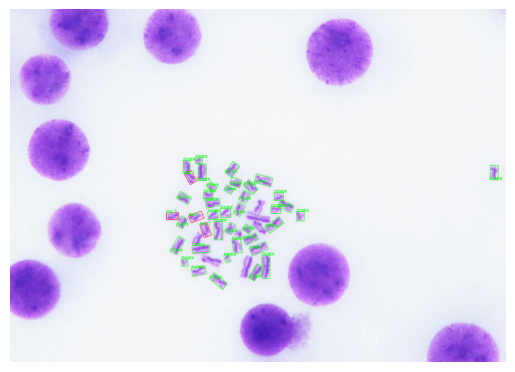

In [ ]:
show_img(img_result2)

In [ ]:
####15回分の合計が入っていますので、平均を出してください
print(Vit_all06/15)
print(Alg_all06/15)
print(Vit_all07/15)
print(Alg_all07/15)
print(Vit_all08/15)
print(Alg_all08/15)
print(Vit_all09/15)
print(Alg_all09/15)

BLM欠損株

In [ ]:
####野生株と構造は同じ
####欠損株画像のディレクトリと正解ラベルに注意
tmp = 0
ExSumlist6 = []
NumSumlist6 = []
ExSumlist7 = []
NumSumlist7 = []
ExSumlist8 = []
NumSumlist8 = []
ExSumlist9 = []
NumSumlist9 = []
ExSum6 = 0
NumSum6 = 0
ExSum7 = 0
NumSum7 = 0
ExSum8 = 0
NumSum8 = 0
ExSum9 = 0
NumSum9 = 0
for k in range(15):
    print('■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■')
    train_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train'
    if os.path.exists(train_dir):
      # print('Y')
      shutil.rmtree(train_dir)
    valtest_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest'
    if os.path.exists(valtest_dir):
      # print('yy')
      shutil.rmtree(valtest_dir)
    os.mkdir(train_dir)
    os.mkdir(valtest_dir)
    train_size = 0.6
    base_dir =  '/content/drive/MyDrive/zemi2/231101vit_sfl/base_data'
    data_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train'
    image_dir_train_test_sprit(base_dir, data_dir, train_size)
    count_file = 0
    train_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/train/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(train_dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(train_dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    count_file = 0
    dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/validation/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    val_size = 119/219
    base_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/validation/'
    val_test_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/'
    image_dir_train_test_sprit(base_dir, val_test_dir, val_size)
    count_file = 0
    val_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/train/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(val_dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(val_dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    count_file = 0
    test_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/validation/ex'
    #ディレクトリの中身分ループ
    for file_name in os.listdir(test_dir):
        #ファイルもしくはディレクトリのパスを取得
        file_path = os.path.join(test_dir,file_name)

        #ファイルであるか判定
        if os.path.isfile(file_path):
            count_file +=1

    print(count_file)
    train_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_train/train'
    val_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/train'
    test_dir = '/content/drive/MyDrive/zemi2/231101vit_sfl/data_valtest/validation/validation'
    device = 'cuda:0'
    train_dataset_dir = Path(train_dir)
    val_dataset_dir = Path(val_dir)
    test_dataset_dir = Path(test_dir)
    train_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomAffine([0,30], scale=(0.8, 1.2)),
            ###９０度回転
            # transforms.RandomRotation(degrees = 90),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )

    val_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )

    test_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    )
    train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
    valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)
    test_data = datasets.ImageFolder(test_dataset_dir, test_transforms)

    train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
    valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=False)
    test_loader = DataLoader(dataset = test_data, batch_size=1, shuffle=False)
    model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
    model = model.to(device)
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    batch_size = 16


    best_loss = None

    # Accuracy計算用の関数
    def calculate_accuracy(output, target):
        output = (torch.sigmoid(output) >= 0.5)
        target = (target == 1.0)
        accuracy = torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
        return accuracy

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)


        print()
    device2 = torch.device('cpu')

    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    for i in range(epochs):
        train_acc2 = train_acc_list[i].to(device2)
        train_acc3 = train_acc2.clone().numpy()
        train_acc.append(train_acc3)

        train_loss2 = train_loss_list[i].to(device2)
        train_loss3 = train_loss2.clone().detach().numpy()
        train_loss.append(train_loss3)

        val_acc2 = val_acc_list[i].to(device2)
        val_acc3 = val_acc2.clone().numpy()
        val_acc.append(val_acc3)

        val_loss2 = val_loss_list[i].to(device2)
        val_loss3 = val_loss2.clone().numpy()
        val_loss.append(val_loss3)

    best_loss = val_loss
    model_path = '/content/drive/MyDrive/zemi2/231127vit/model/ViTmodel.pth'
    torch.save(model.state_dict(), model_path)


    chrome_metadata = MetadataCatalog.get("chrome")
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 1クラスのみ
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/zemi2/231226/model_final (1).pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
    cfg.MODEL.DEVICE = "cpu"
    predictor = DefaultPredictor(cfg)
    #model
    model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
    # Load a model
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    ExSum6 = 0
    NumSum6= 0
    ExSum7 = 0
    NumSum7 = 0
    ExSum8 = 0
    NumSum8 = 0
    ExSum9 = 0
    NumSum9 = 0

    Ex6 = 0
    Num6= 0
    Ex7 = 0
    Num7 = 0
    Ex8 = 0
    Num8 = 0
    Ex9 = 0
    Num9 = 0
    lis = [40,41,42,43,44,45,46,47,48,49]
    c_per_ave=0
    c_per6_ave=0
    c_per7_ave=0
    c_per8_ave=0
    c_per9_ave=0
    m_per_ave=0
    m_per6_ave=0
    m_per7_ave=0
    m_per8_ave=0
    m_per9_ave=0

    ###テスト
    for i in lis:
      lum_per = 0
      all_lum = 0
      all_sin = 0

      sin_list = []
      lum_list = []
      RED = '\033[31m'
      END = '\033[0m'
      ###保存
      save_path = '/content/drive/MyDrive/zemi2/cell/ViT0520/wt220219'
      # imgPath = "/content/drive/MyDrive/zemi2/cell/cell/0427_wt30min/"+str(i)+".png"
      imgPath = "/content/drive/MyDrive/zemi2/cell/cell/0427_blm30min/"+str(i)+".png"
      im = cv2.imread(imgPath)
      img_result2 = cv2.imread(imgPath)
      outputs = predictor(im)
      masks =  outputs["instances"].to("cpu").pred_masks
      masks_np = np.empty((len(masks[1])))
      masks_np = masks.to('cpu').detach().numpy().copy()
      masks_np = masks_np.astype(np.uint8)
      out_class = outputs["instances"].to("cpu").pred_classes
      scores = outputs["instances"].to("cpu").scores
      ### マスク
      masks_np = np.empty((len(masks[1])))
      masks_np = masks.to('cpu').detach().numpy().copy()
      # print(masks_np)
      masks_np = masks_np.astype(np.uint8)
      if i==40:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
        Vit_list = [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1]
        Alg_list =[0, 2, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2]
        errViTlist=[0, 1, 0, 0, 1, 1, 1]
        errAlglist=[0, 3, 0, 0, 2, 3, 2]
      if i==41:
        handan_list =[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
        Vit_list =[0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
        Alg_list =[0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2]
        errViTlist=[0, 0, 0]
        errAlglist=[0, 0, 0]
      if i==42:
        handan_list = [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1]
        Vit_list =[0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]
        Alg_list =[0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 3, 2, 0, 2, 0, 1]
        errViTlist=[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
        errAlglist=[0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1]
      if i==43:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
        Vit_list =[1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
        Alg_list=[2, 1, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2]
        errViTlist=[0, 0, 0, 1, 1, 0]
        errAlglist=[0, 0, 0, 2, 1, 0]
      if i==44:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
        Vit_list =[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
        Alg_list=[1, 0, 2, 1, 1, 0, 2, 1, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1]
        errViTlist=[0]
        errAlglist=[0]
      if i==45:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
        Vit_list =[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]
        Alg_list=[0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2]
        errViTlist=[0, 0, 0, 0, 0, 0, 1, 0]
        errAlglist=[0, 0, 0, 0, 0, 0, 2, 0]
      if i==46:
        handan_list = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
        Vit_list=[1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
        Alg_list=[2, 0, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 2, 2]
        errViTlist=[0, 0, 0, 0, 0]
        errAlglist=[0, 0, 0, 0, 0]
      if i==47:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
        Vit_list=[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]
        Alg_list=[0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1]
        errViTlist=[0, 0, 1, 0, 0, 1]
        errAlglist=[0, 0, 2, 0, 0, 2]
      if i==48:
        handan_list =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Vit_list=[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]
        Alg_list=[2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 0, 2, 2, 1, 1, 1, 0, 0, 2, 2, 2]
        errViTlist=[0]
        errAlglist=[1]
      if i==49:
        handan_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
        Vit_list=[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]
        Alg_list=[0, 1, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0, 3, 2, 1, 2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 1]
        errViTlist=[0, 0]
        errAlglist=[0, 0]
      all_cnt, img_result2, chrome_num, chrome_list,Exlist6, Exlist7,Exlist8,Exlist9,\
      Numlist6, Numlist7,Numlist8,Numlist9,ExNum, MokushiNum, sin_list,lum_list,\
      errExNum,errMokushiNum\
      ,chrome_list6,chrome_list7,chrome_list8,chrome_list9\
      ,mks_list6,mks_list7,mks_list8,mks_list9\
      = chrome_judge(masks_np,im, img_result2, save_path,model, scores, out_class,handan_list,Vit_list,Alg_list,errViTlist,errAlglist)
      print('---------------------')
      print(i)
      print('count excange = '+str(all_cnt))
      print('検出染色体数'+str(len(chrome_list)))
      c_per = sum(chrome_list)/len(chrome_list)
      print("per_exchange = "+str(c_per))

      c_per6 = sum(chrome_list6)/len(chrome_list6)
      print("per_exchange6 = "+str(c_per6))
      c_per7 = sum(chrome_list7)/len(chrome_list7)
      print("per_exchange7 = "+str(c_per7))
      c_per8 = sum(chrome_list8)/len(chrome_list8)
      print("per_exchange8 = "+str(c_per8))
      try:
        c_per9 = sum(chrome_list9)/len(chrome_list9)
      except:
        c_per9=0
      print("per_exchange9 = "+str(c_per9))
      c_per_ave+=c_per
      c_per6_ave+=c_per6
      c_per7_ave+=c_per7
      c_per8_ave+=c_per8
      c_per9_ave+=c_per9
      c_per_Mokushi = sum(MokushiNum)/len(MokushiNum)
      print("mks_exchange = "+str(c_per_Mokushi))
      m_per6 = sum(mks_list6)/len(mks_list6)
      print("per_exchange6 = "+str(c_per6))
      m_per7 = sum(mks_list7)/len(mks_list7)
      print("per_exchange7 = "+str(m_per7))
      m_per8 = sum(mks_list8)/len(mks_list8)
      print("per_exchange8 = "+str(m_per8))
      try:
        m_per9 = sum(mks_list9)/len(mks_list9)
      except:
        m_per9=0
      print("per_exchange9 = "+str(m_per9))
      m_per_ave+=c_per_Mokushi
      m_per6_ave+=m_per6
      m_per7_ave+=m_per7
      m_per8_ave+=m_per8
      m_per9_ave+=m_per9
      ###交換正解率,回数正解率
      if len(Exlist6)==0:
        print('-----0.6検出数:0')
        print(RED + '交換正解率0.6：0'+END)
      else:
        ExPred6 = 1-(sum(Exlist6)/len(Exlist6))
        print('-----0.6検出数:'+str(len(Exlist6)))
        print(RED + '交換正解率0.6：'+str(ExPred6)+END)
      if len(Numlist6)==0:
        print('-----0.6画像処理対象数:0')
        print(RED + '回数正解率0.6：0'+END)
      else:
        NumPred6 =  1-(sum(Numlist6)/len(Numlist6))
        print('-----0.6画像処理対象数:'+str(len(Numlist6)))
        print(RED + '回数正解率0.6：'+str(NumPred6)+END)
    ####
      if len(Exlist7)==0:
        print('-----0.7検出数:0')
        print(RED + '交換正解率0.7：0'+END)
      else:
        ExPred7 = 1-(sum(Exlist7)/len(Exlist7))
        print('-----0.7検出数:'+str(len(Exlist7)))
        print(RED + '交換正解率0.7：'+str(ExPred7)+END)
      if len(Numlist7)==0:
        print('-----0.7画像処理対象数:0')
        print(RED + '回数正解率0.7：0'+END)
      else:
        NumPred7 =  1-(sum(Numlist7)/len(Numlist7))
        print('-----0.7画像処理対象数:'+str(len(Numlist7)))
        print(RED + '回数正解率0.7：'+str(NumPred7)+END)
    ###
      if len(Exlist8)==0:
        print('-----0.8検出数:0')
        print(RED + '交換正解率0.8：0'+END)
      else:
        ExPred8 = 1-(sum(Exlist8)/len(Exlist8))
        print('-----0.8検出数:'+str(len(Exlist8)))
        print(RED + '交換正解率0.8：'+str(ExPred8)+END)
      if len(Numlist8)==0:
        print('-----0.8画像処理対象数:0')
        print(RED + '回数正解率0.8：0'+END)
      else:
        NumPred8 =  1-(sum(Numlist8)/len(Numlist8))
        print('-----0.8画像処理対象数:'+str(len(Numlist8)))
        print(RED + '回数正解率0.8：'+str(NumPred8)+END)
    ###
      if len(Exlist9)==0:
        print('-----0.9検出数:0')
        print(RED + '交換正解率0.9：0'+END)
      else:
        ExPred9 = 1-(sum(Exlist9)/len(Exlist9))
        print('-----0.9検出数:'+str(len(Exlist9)))
        print(RED + '交換正解率0.9：'+str(ExPred9)+END)
      if len(Numlist9)==0:
        print('-----0.9画像処理対象数:0')
        print(RED + '回数正解率0.9：0'+END)
      else:
        NumPred9 =  1-(sum(Numlist9)/len(Numlist9))
        print('-----0.9画像処理対象数:'+str(len(Numlist9)))
        print(RED + '回数正解率0.9：'+str(NumPred9)+END)

      print('単一と検出した数：'+str(len(sin_list)))
      print(sin_list)
      print('交換のありなし')
      print(ExNum)
      print('回数')
      print(MokushiNum)
      print('複数と検出した数：'+str(len(lum_list)))
      print(lum_list)
      print('errViTlist=')
      print(errExNum)
      print('errAlglist=')
      print(errMokushiNum)
      ExSum6 += len(Exlist6)
      NumSum6+= len(Numlist6)
      ExSum7 += len(Exlist7)
      NumSum7+= len(Numlist7)
      ExSum8 += len(Exlist8)
      NumSum8+= len(Numlist8)
      ExSum9 += len(Exlist9)
      NumSum9+= len(Numlist9)
      ExSumlist6 += Exlist6
      NumSumlist6+= Numlist6
      ExSumlist7 += Exlist7
      NumSumlist7+= Numlist7
      ExSumlist8 += Exlist8
      NumSumlist8+= Numlist8
      ExSumlist9 += Exlist9
      NumSumlist9+= Numlist9
    c_per_ave/=len(lis)
    c_per6_ave=c_per6_ave/len(lis)
    c_per7_ave=c_per7_ave/len(lis)
    c_per8_ave=c_per8_ave/len(lis)
    c_per9_ave=c_per9_ave/len(lis)
    m_per_ave=m_per_ave/len(lis)
    m_per6_ave=m_per6_ave/len(lis)
    m_per7_ave=m_per7_ave/len(lis)
    m_per8_ave=m_per8_ave/len(lis)
    m_per9_ave=m_per9_ave/len(lis)
    # print(c_per_ave)
    # print(c_per6_ave)
    # print(c_per7_ave)
    # print(c_per8_ave)
    # print(c_per9_ave)
    # print(m_per_ave)
    # print(m_per6_ave)
    # print(m_per7_ave)
    # print(m_per8_ave)
    # print(m_per9_ave)
    print('信頼度0.6：'+str(c_per6_ave)+(':')+str(m_per6_ave))
    print('信頼度0.7：'+str(c_per7_ave)+(':')+str(m_per7_ave))
    print('信頼度0.8：'+str(c_per8_ave)+(':')+str(m_per8_ave))
    print('信頼度0.9：'+str(c_per9_ave)+(':')+str(m_per9_ave))
    Ex_tmp = (Ex6+Ex7+Ex8+Ex9)/4
    # if Ex_tmp>tmp:
    #   bmodel_path = '/content/drive/MyDrive/zemi2/231127vit/model/ViTmodel_best.pth'
    # torch.save(model.state_dict(), bmodel_path)
    print('■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■')